In [57]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [32]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel10  ...  pixel7

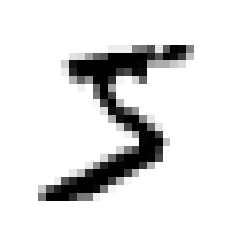

In [33]:
X, y = mnist['data'], mnist['target']
print(X)

y = y.astype(np.uint8)
print(y)

some_digit = X.loc[0]
some_digit_image = some_digit.values.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [34]:
X_train, X_test, y_train, y_test = X[:6000], X[6000:], y[:6000], y[6000:]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

## Precision and Recall score of a classification model.
## F1 score to find the harmonious mean of precision and recall.

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

confusion_matrix(y_train_5, y_train_pred)

prec_score = precision_score(y_train_5, y_train_pred)
print(prec_score)

rec_score = recall_score(y_train_5, y_train_pred)
print(rec_score)

f1 = f1_score(y_train_5, y_train_pred)
print(f1)



0.7801980198019802
0.7665369649805448
0.7733071638861628


[38042.34312442]


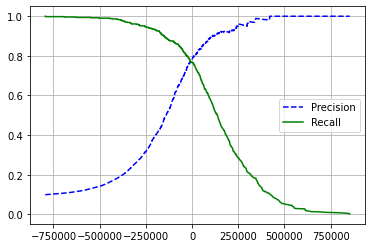

0.9012345679012346
0.5680933852140078


In [44]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 800
y_some_digit_pred = (y_scores > threshold)

y_score = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_score)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.grid()
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_score >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

## Receiver Operating Characteristics (ROC) curve plots TPR (recall) against FPR.
### - A good classifier stays far away from the diagonal dashed line
## To compare classifiers, measure the area under the curve (AUC) 
### - A perfect classier has ROC AUC = 1, while a random classifier has ROC AUC = 0.5

## Use precision/recall (PR) curve if the positive class is rare or if you care more about the false positives than the false negatives.
## Use ROC curve otherwise.

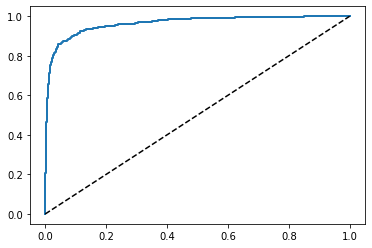

0.9641599203348885


In [48]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_score)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()    

print(roc_auc_score(y_train_5, y_score))

[[0.37 0.63]
 [0.98 0.02]
 [0.95 0.05]
 ...
 [0.67 0.33]
 [0.99 0.01]
 [0.9  0.1 ]]


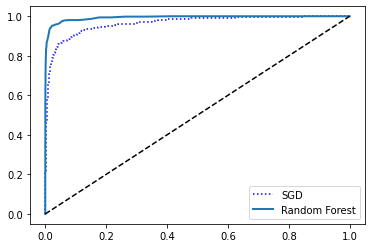

AUC  0.9936162229715256


In [51]:
forest_clf = RandomForestClassifier(random_state=42)
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
print(y_prob_forest)
y_score_forest = y_prob_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_score_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend()
plt.show()

print("AUC ", roc_auc_score(y_train_5, y_score_forest))

## Support Vector Machine uses one-vs-one (OvO) strategy

In [54]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])
some_digit_score = svm_clf.decision_function([some_digit])
print(some_digit_score)
print(np.argmax(some_digit_score))
print(svm_clf.classes_)


[[ 1.74201669  3.75934047  6.18134457  8.29644372 -0.30252035  9.30527336
   1.74930094  2.77838477  7.19221016  3.87315474]]
5
[0 1 2 3 4 5 6 7 8 9]


In [55]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [59]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
print(sgd_clf.decision_function([some_digit]))

print("Accuracy with X", cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print("Accuracy with Scaled X ", cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))

[[-735711.69660953 -857058.38635209 -281086.00104909    8289.73273042
  -616793.26669143   29040.2961313  -492305.02284074 -834395.17091855
  -318385.3774766  -363474.38706356]]
Accuracy with X [0.8565 0.8715 0.8635]
Accuracy with Scaled X  [0.8705 0.8985 0.8925]


[[572   0   1   2   1   9   3   1   3   0]
 [  0 637   6   3   1   5   0   1  16   2]
 [ 10  12 493  11  10   4  10   9  20   2]
 [  3   5  21 514   1  35   1   7  11  10]
 [  3   2   7   0 556   2  10   8   9  26]
 [  5   6   5  24  14 411  10   1  25  13]
 [  4   4   6   0   5   6 577   1   5   0]
 [  3   4   7   2   9   0   1 577   3  45]
 [  2  19  13  16   4  10   6   3 464  14]
 [  7   4   5   7  15   3   0  27  11 522]]


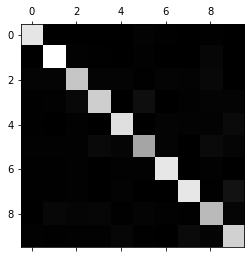

In [60]:
y_train_prediction = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_prediction)
print(conf_mx)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

## The confusion matrix looks goot as most images are on the main diagonal => classified correctly.

## In confusion matrix, the rows represent actual classes, while columns represent predicted classes.

## To plot the error, u need to divide each value in the confusion matrix by the no. images in the corresponding class.
### The column of class 8 is quite bright, as many images get misclassified as 8.
### 3 and 5 often get confused.

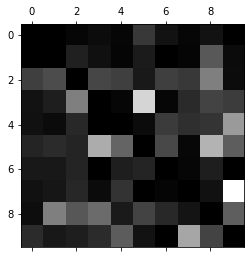

In [61]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [63]:
# Multilabel Classification

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
print(knn_clf.predict([some_digit]))

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

[[False  True]]
0.9500922726736858


(6000, 784)
       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
6000     76.0    15.0    24.0    80.0    95.0    92.0    84.0     9.0    85.0   
6001     34.0    15.0    24.0    56.0    67.0    55.0    34.0    30.0     7.0   
6002     82.0    88.0    27.0    99.0     5.0    36.0     5.0    74.0    70.0   
6003     47.0    72.0    77.0    80.0    42.0    49.0    64.0    68.0    87.0   
6004     29.0    62.0    59.0     5.0    99.0    47.0    60.0    13.0    71.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69995    84.0    29.0    22.0    48.0    16.0    52.0    38.0    91.0    70.0   
69996    58.0    49.0     3.0    73.0    88.0    27.0    11.0    58.0    65.0   
69997    45.0    69.0    90.0    16.0    22.0    88.0    10.0    25.0    59.0   
69998    16.0     1.0    59.0    51.0    48.0    60.0    96.0    36.0    94.0   
69999    61.0    34.0    98.0    82.0    56.0    51.0    35.0    39.0    43.0   

       pixel10 

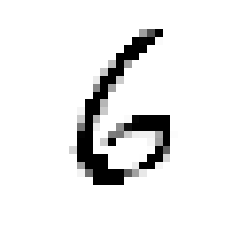

In [90]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
print(X_train_mod.shape)
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
print(X_test_mod)

y_train_mod = X_train
y_test_mod = X_test
print(y_test_mod.shape)
print(y_train_mod.shape)
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.loc[6000]])

plot_digits(clean_digit)